## First: import necessary modules

In [1]:
#imports

%matplotlib widget

# python core
import os
import datetime as dt
from collections import defaultdict

# python libraries
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

# themachinethatgoesping modules
import themachinethatgoesping as Ping
from themachinethatgoesping.echosounders import kongsbergall, index_functions, simradraw

## Open files from a survey

#### Get pings

In [2]:
# define a list of folder(s) to search for raw data files
folders = []

folders = ["../unittest_data/"]
folders = ["/home/data/turbeams/TURBEAMS_data_crunshing/campaigns/05_TURBEAMS_April_2023/Stations/"]
folders.append("/home/data/turbeams/TURBEAMS_data_crunshing/campaigns/05_TURBEAMS_April_2023/Transect/")
#folders = ["/home/data/test_data/yoann/"]
#folders = ["/home/data/test_data/alex_yolla/"]

#folders = ["/home/data/test_data/alex_big/"]

# find all .all/.wcd files and cache file positions
files = index_functions.find_files(folders, [".raw"])
cache_files = index_functions.get_cache_file_paths(files)
files2 = index_functions.find_files(folders, [".all",".wcd"])
cache_files2 = index_functions.get_cache_file_paths(files)

# open all files and index
fm = simradraw.SimradRawFileHandler(files,cache_files, init=False)    
fm.navigation_interface.set_min_gga_quality(4)
fm.navigation_interface.init_from_file(file_cache_paths=cache_files)
fm.ping_interface.init_from_file(file_cache_paths=cache_files)

# change heave direction
for p in tqdm(fm.get_pings(), delay =5):    
    s = p.get_sensor_data_latlon()
    s.heave = -s.heave
    p.set_sensor_data_latlon(s)

    c = p.get_sensor_configuration()
    c.set_depth_source("0",0,0,1.75)
    c.set_position_source("0",0,0,0)

fm2 = kongsbergall.KongsbergAllFileHandler(files2,cache_files2)    

pings_per_station_mbes = Ping.pingprocessing.split_pings.by_time_difference(fm2.get_pings(), 1000)
pings_per_station_sbes = Ping.pingprocessing.split_pings.by_time_difference(fm.get_pings(), 1000)

del fm, fm2
Ping.pingprocessing.core.clear_memory()

Found 659 files
Found 288 files
indexing files ⠁ 99% :13s<00m:00s] [Found: 4033171 datagrams in 659 files (56889MB)]                                                 
Initializing SimradRawConfigurationDataInterface from file data ⠐ 100% :00s<00m:00s] [Done]            
Initializing SimradRawNavigationDataInterface from file data ⠁ 100% :44s<00m:00s] [Done]            
Initializing SimradRawPingDataInterface from file data ⢀ 99% :08s<00m:00s] [Done]                                              
indexing files ⠄ 100% :33s<00m:00s] [..1_114812_Belgica.wcd (288/288)]                                  
indexing files ⠂ 100% :33s<00m:00s] [Found: 5130471 datagrams in 288 files (25571MB)]                                                 
Initializing navigation ⠐ 96% :04s<00m:00s] [141/144]                   
Initializing ping interface ⠈ 99% :12s<00m:00s] [Done]                                              


## Overview and filter pings

#### plot navigation data data

In [ ]:
background_map = "/home/data/turbeams/TURBEAMS_data_crunshing/campaigns/BPNS_latlon.tiff"

fig, ax = Ping.pingprocessing.overview.nav_plot.create_figure(
    "Navigation data", aspect="auto", background_image_path=background_map, cmap="Greys_r"
)

for station, pings in pings_per_station_sbes.items():
    print(f"plotting overview for station: {station}...", end="\r")
    stats = Ping.pingprocessing.overview.get_ping_overview(pings)
    stats.plot_navigation(ax, label=station)

print(f"plotting overview for stations: Done    ")
ax.legend()

#### filter pings

In [4]:
# select station
station = 2

pings = pings_per_station[station]

#only pings that contain watercolumn data
pings = Ping.pingprocessing.filter_pings.by_features(pings, ['watercolumn.av'])

#group pings by channel_id
pings_per_channel = Ping.pingprocessing.split_pings.by_channel_id(pings)

for channel, pings in pings_per_channel.items():
    print(f'{channel}:, {len(pings)}')

TRX-2031:, 27328
TRX-2004:, 27328


## Preprocess (beam specifications)

#### get mean beam angle per beam_nr

In [5]:
apply_pss_to_bottom = True

angle_ranges = defaultdict(list)
for channel, pings in pings_per_channel.items():
    beam_angle = defaultdict(list)
    for ping in tqdm(pings, desc=f'Processing channel {channel}'):
        if apply_pss_to_bottom:
            for bn,ba in enumerate(ping.bottom.get_beam_crosstrack_angles()):
                beam_angle[bn].append(ba)
        else:
            for bn,ba in enumerate(ping.watercolumn.get_beam_crosstrack_angles()):
                beam_angle[bn].append(ba)

    for bn,ba in beam_angle.items():
        d = 1.5*(np.nanquantile(ba,0.75)- np.nanquantile(ba,0.25))
        m = np.median(ba)
        ba = np.array(ba)
        ba = ba[ba >= m-d]
        ba = ba[ba <= m+d]
         
        angle_ranges[channel].append((m, np.min(ba)-0.1, np.min(ba)+0.1))
        #print(bn, round(angle_ranges[channel][-1][0],2), round(angle_ranges[channel][-1][1],2), round(angle_ranges[channel][-1][2],2))
        
    print(f'{channel}: {len(angle_ranges[channel])} ({round(angle_ranges[channel][0][0],2)} - {round(angle_ranges[channel][-1][0],2)})')

Processing channel TRX-2031:   0%|          | 0/27328 [00:00<?, ?it/s]

TRX-2031: 256 (67.93000030517578 - -25.229999542236328)


Processing channel TRX-2004:   0%|          | 0/27328 [00:00<?, ?it/s]

TRX-2004: 256 (24.81999969482422 - -70.0199966430664)


In [6]:
a = [1,2,3]
b = [4,5,6]
c = np.array([a,b])

[ping for ping_list in c for ping in ping_list]

[1, 2, 3, 4, 5, 6]

In [233]:
def resample(angles_and_pings, angle_stepsize=1/3, angle_max_diff=1/3):
    a = angles_and_pings.copy()
    angles = np.arange(np.nanmin(a.index), np.nanmax(a.index)+angle_stepsize, angle_stepsize)
    I = Ping.tools.vectorinterpolators.NearestInterpolatorFI(angles, np.arange(len(angles)))

    drop_angs = []
    for ang in a.index:
        new_ang = angles[I(ang)]
        if abs(new_ang - ang) > angle_max_diff/2:
            drop_angs.append(ang)
    a.drop(drop_angs, inplace=True)
    print(len(drop_angs))

    a = a.groupby(I).apply(lambda x: 
                           sorted(
                               list(set([ping for ping_vec in x.values for ping_list in ping_vec for ping in ping_list])),
                               key = lambda ping : ping.get_timestamp()
                           ) 
                          )
    A = pd.DataFrame()
    A['angle'] = angles[a.index]
    A['min_angle'] = A['angle'].values - angle_max_diff * 0.6
    A['max_angle'] = A['angle'].values + angle_max_diff * 0.6
    A['pings'] = a
    A.set_index('angle', inplace=True)
    A.dropna(inplace=True)
    return A

#fig,ax = Ping.pingprocessing.core.create_figure(' angles2')
#b = resample(angle_ranges_and_pings[channel],0.1,0.005)

#ax.scatter(b.index, [len(pings) for pings in b['pings']], label = 'b')
#print(len(b))

Processing channel TRX-2031:   0%|          | 0/27328 [00:00<?, ?it/s]

3
dropped 11


Processing channel TRX-2004:   0%|          | 0/27328 [00:00<?, ?it/s]

0
dropped 11


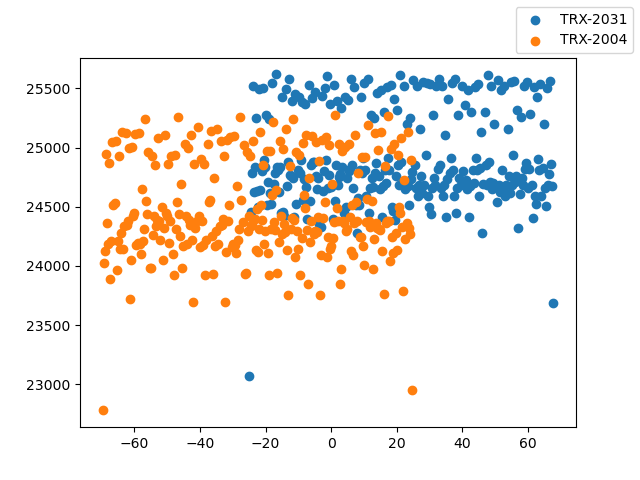

In [263]:
#compute 256 median beam angles

fig,ax = Ping.pingprocessing.core.create_figure(' angles')

apply_pss_to_bottom = True

angle_ranges_and_pings = defaultdict(pd.DataFrame)
for channel, pings in pings_per_channel.items():
    npings = len(pings)
    beam_angles = defaultdict(list)
    for pn,ping in enumerate(tqdm(pings, desc=f'Processing channel {channel}')):
        if apply_pss_to_bottom:
            for bn,ba in enumerate(ping.bottom.get_beam_crosstrack_angles()):
                beam_angles[ba].append(ping)
        else:
            for bn,ba in enumerate(ping.watercolumn.get_beam_crosstrack_angles()):
                beam_angles[ba].append(ping)

    # remove unfrequent frequencies
    freqs = [len(pings) for pings in beam_angles.values()]
    min_freq = np.nanquantile(freqs,0.05)
    min_freq = np.nanmean(freqs)*0.75

    if False:
        for k in list(beam_angles.keys()):
            if len(beam_angles[k]) < min_freq:
                del beam_angles[k]

    
    angle_ranges_and_pings[channel]['angle'] = list(beam_angles.keys())
    angle_ranges_and_pings[channel]['pings'] = [pings for pings in beam_angles.values()]
    angle_ranges_and_pings[channel].set_index('angle', inplace=True)

    angle_ranges_and_pings[channel] = resample(angle_ranges_and_pings[channel])

    drop =[]
    for column in angle_ranges_and_pings[channel].iloc:
        if len(column['pings']) < 0.8 * npings:
            drop.append(column.name)

    print('dropped', len(drop))
    angle_ranges_and_pings[channel].drop(drop, inplace=True)
    
    ax.scatter(angle_ranges_and_pings[channel].index, [len(pings) for pings in angle_ranges_and_pings[channel]['pings']], label = channel)

fig.legend()
        

In [298]:
layers = [6,8,10,12,14,16,18]
layer_size = 2


def plot_echogram(ax, echogram, plot_bottom = True, plot_minslant = True, **kwargs):
    image,extent = echogram.build_image()

    _kwargs = {
        'cmap' : 'YlGnBu_r',
        'aspect' : 'auto',
        'vmin' : -90,
        'vmax' : -50    
    }
    _kwargs.update(kwargs)
    
    ax.imshow(image.transpose(), extent=extent, **_kwargs)
    if plot_bottom:
        ax.plot(*echogram.get_ping_param('bottom'), label='bottom', color = 'black')
    if plot_minslant:
        ax.plot(*echogram.get_ping_param('minslant'), label='minslant', color = 'red')

def cut_minslant(echogram):
    x, minslant = echogram.get_ping_param('minslant')
    minslant = np.array(minslant) - 1
    
    new_echogram = echogram.get_filtered_by_y_extent(x, np.zeros(len(x)), minslant)
    new_echogram.set_x_axis_date_time()
    new_echogram.set_y_axis_depth()
    return new_echogram

# def cut_minslant_layer(echogram):
#     x, minslant = echogram.get_ping_param('minslant')
#     minslant = np.array(minslant) - 1
#     minslant0 = minslant - layer_size
    
#     new_echogram = echogram.get_filtered_by_y_extent(x, minslant0, minslant)
#     new_echogram.set_x_axis_date_time()
#     new_echogram.set_y_axis_depth()
#     return new_echogram
    
def cut_layers(echogram):
    echogram_layers = {}
    
    for layer in layers:
        x = [echogram.vec_x_val[0],echogram.vec_x_val[-1]]
        min_y = [layer - layer_size/2, layer - layer_size/2]
        max_y = [layer + layer_size/2, layer + layer_size/2]
        
        new_echogram = echogram.get_filtered_by_y_extent(x, min_y, max_y)
        new_echogram.set_x_axis_date_time()
        new_echogram.set_y_axis_depth()
        echogram_layers[layer] = new_echogram
    return echogram_layers

## Plot 2 echograms for testing

In [299]:
def make_echogram(angle_range_and_pings):
    pss = Ping.echosounders.pingtools.PingSampleSelector()
    add_off = 0.0
    pss.select_beam_range_by_angles(angle_range_and_pings['min_angle']-add_off, angle_range_and_pings['max_angle']+add_off)
    pings=angle_range_and_pings['pings']
    echogram = Ping.pingprocessing.watercolumn.echograms.EchoData.from_pings(
        angle_range_and_pings['pings'][::pingstep], 
        pss=pss, 
        apply_pss_to_bottom=apply_pss_to_bottom,
        linear_mean=False,
    verbose=False)

    
    echogram.set_x_axis_date_time()
    echogram.set_y_axis_depth()
    return echogram

In [310]:
channel = 'TRX-2004'
pingstep=3

#create two echograms fro comparisson
pss_base = Ping.echosounders.pingtools.PingSampleSelector()

pss_base.select_beam_range_by_angles(-1,1)

echogram_base = Ping.pingprocessing.watercolumn.echograms.EchoData.from_pings(
    pings_per_channel[channel][::pingstep], 
    pss=pss_base, 
    apply_pss_to_bottom=False,
        linear_mean=False)
echogram_base.set_x_axis_date_time()
echogram_base.set_y_axis_depth()

echogram_comp = make_echogram(angle_ranges_and_pings[channel].iloc[-1])

 39%|###9      | 3566/9110 [00:01<00:01, 3565.33it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

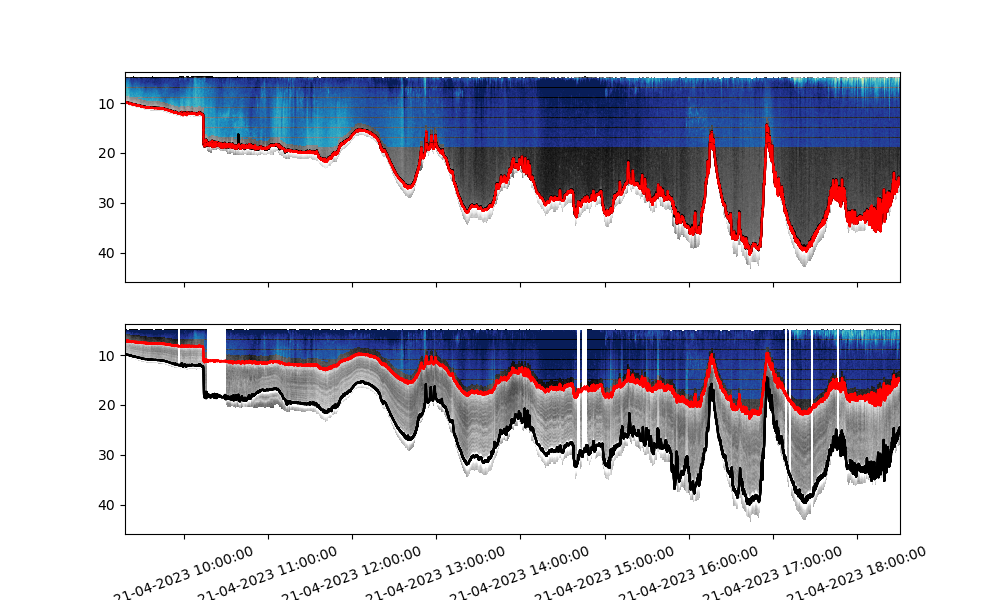

In [311]:
## plot
fig = Ping.pingprocessing.core.create_figure('Echogram comparison', return_ax = False)
fig.set_size_inches(10,6)
ax1,ax2 = fig.subplots(nrows = 2, sharex=True, sharey=True)

plot_echogram(ax1, echogram_base, cmap='Greys_r')
plot_echogram(ax2, echogram_comp, cmap='Greys_r')

echogram_base_cut = cut_minslant(echogram_base)
echogram_comp_cut = cut_minslant(echogram_comp)
#plot_echogram(ax1, echogram_base_cut)
#plot_echogram(ax2, echogram_comp_cut)

echogram_layers_base = cut_layers(echogram_base_cut)
echogram_layers_comp = cut_layers(echogram_comp_cut)

for layer in tqdm(layers):
    plot_echogram(ax1, echogram_layers_base[layer])
    plot_echogram(ax2, echogram_layers_comp[layer])

# echogram_base_minslant_layer = cut_minslant_layer(echogram_base)
# echogram_comp_minslant_layer = cut_minslant_layer(echogram_comp)
# plot_echogram(ax1, echogram_base_minslant_layer, cmap='jet')
# plot_echogram(ax2, echogram_comp_minslant_layer, cmap='jet')

Ping.pingprocessing.core.set_ax_timeformat(ax2, rotation=20)

In [312]:
import pandas as pd
import datetime as dt
from collections import defaultdict

def get_data_per_layer(channel, angle_step=1):
    data_per_layer = defaultdict(pd.DataFrame)
    
    for layer in layers:
        data = data_per_layer[layer]
        data['time'] = echogram_base.ping_times
        data['datetime'] = [dt.datetime.fromtimestamp(t, dt.timezone.utc) for t in echogram_base.ping_times]
        data['base'] = [np.nanmean(wc) for wc in echogram_layers_base[layer].wc_data]
        data.set_index('datetime', inplace=True)
        data_per_layer[layer] = data.resample('10Min').apply(np.nanmedian)
    
    angles = []
    down_angles_and_pings = angle_ranges_and_pings[channel].iloc[::angle_step]
    for angle_range_and_pings in tqdm(down_angles_and_pings.iloc, total = len(down_angles_and_pings)):
        echogram= make_echogram(angle_range_and_pings)
        
        echogram_cut = cut_minslant(echogram)
        echogram_layers = cut_layers(echogram_cut)

        angle = angle_range_and_pings.name
        angles.append(round(angle,2))
        for layer, layer_echogram in echogram_layers.items():
            data = pd.DataFrame()
            data['time'] = layer_echogram.ping_times
            data['datetime'] = [dt.datetime.fromtimestamp(t, dt.timezone.utc) for t in layer_echogram.ping_times]
            data['wc_data'] = [np.nanmean(wc) for wc in layer_echogram.wc_data]
            data.set_index('datetime', inplace=True)
            data = data.resample('10Min').apply(np.nanmedian)
                                            
            data_per_layer[layer][round(angle,2)] = data['wc_data']

    return angles, data_per_layer
    
def get_angle_data(angles, data_per_layer):
    
    angle_data = pd.DataFrame()
    angle_data['angle'] = angles
    angle_data = angle_data.set_index('angle')
    
    for layer in layers:
        data = data_per_layer[layer]
        data = data.dropna()
        #data = data.set_index('datetime')
        #data = data.resample('10Min').apply(np.nanmean)
    
        ref = np.nanmedian(data['base'])
        angle_values = []
        for angle in angles:
            angle_values.append(np.nanmedian(data[angle]) - ref)
    
        angle_data[layer] = angle_values

    return angle_data

In [313]:
def watercolumn_angles(channel,bangles):
    if apply_pss_to_bottom == False:
        return bangles
    ping = pings_per_channel[channel][10000]
    sort_arg = np.argsort(ping.bottom.get_beam_crosstrack_angles())
    I = Ping.tools.vectorinterpolators.AkimaInterpolatorFF(
        ping.bottom.get_beam_crosstrack_angles()[sort_arg], 
        ping.watercolumn.get_beam_crosstrack_angles()[sort_arg])
    
    angles = I(bangles)
    return angles

In [314]:
layer_data = {}
for channel in pings_per_channel.keys():
    angles, data_per_layer = get_data_per_layer(channel, 1)
    layer_data[channel] = angles, data_per_layer

  0%|          | 0/279 [00:00<?, ?it/s]

  0%|          | 0/284 [00:00<?, ?it/s]

In [315]:

angle_data = {}
for channel,(angles, data_per_layer) in layer_data.items():
    angle_data[channel] = get_angle_data(*layer_data[channel])

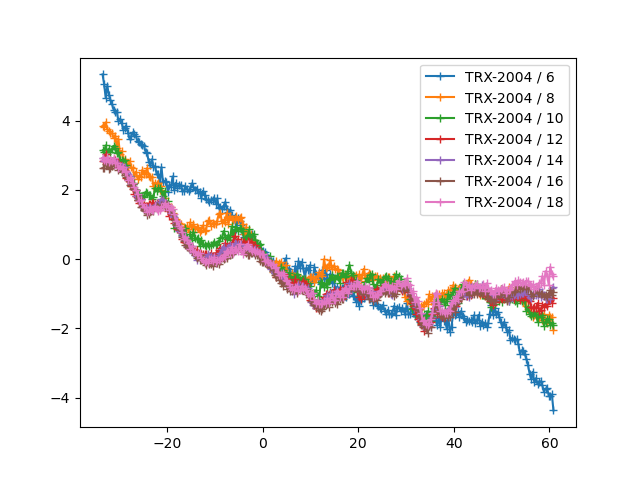

In [316]:
channel='TRX-2004'
fig,ax = Ping.pingprocessing.core.create_figure(f'{channel} angle offsets per layer')

for layer in layers:
    #if not layer > 8:
    #    continue
    bangles = angle_data[channel].index
    wangles = watercolumn_angles(channel, bangles)
    ax.plot(wangles, angle_data[channel][layer], label=f'{channel} / {layer}', marker='+')

ax.legend()

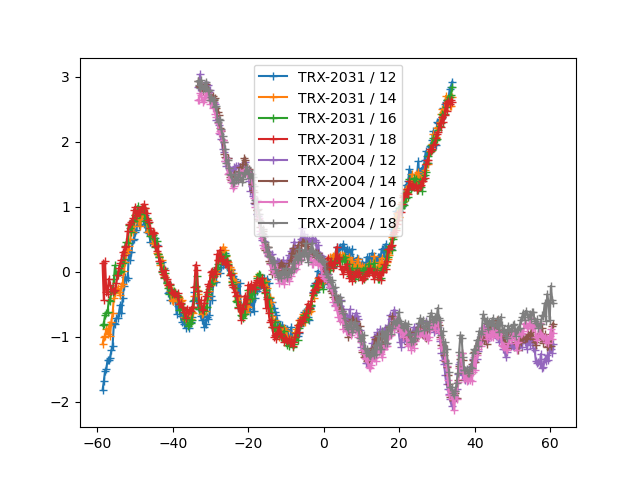

In [321]:

fig,ax = Ping.pingprocessing.core.create_figure('angle offsets per layer')

for channel in angle_data.keys():
    for layer in layers:
        if layer < 12:
            continue
        
        bangles = angle_data[channel].index
        wangles = watercolumn_angles(channel, bangles)
        angle_data[channel]['water_angle'] = wangles
            
        ax.plot(wangles, angle_data[channel][layer], label=f'{channel} / {layer}', marker='+')

ax.legend()

In [332]:
for channel in angle_data.keys():
    angle_data[channel].to_excel(f'calib-{channel}.xlsx')

import pickle
with open('layer-data.pkl', 'wb') as ofi:
    pickle.dump(data_per_layer,ofi)

In [328]:
data_per_layer[6]

,time,base,-69.7,-69.37,-69.04,-68.7,-68.37,-68.04,-67.7,-67.37,...,21.63,21.96,22.3,22.63,22.96,23.3,23.63,23.96,24.3,24.63
datetime,,,,,,,,,,,,,,,,,,,,,
2023-04-21 09:10:00+00:00,1.682069e+09,-76.189911,-71.153587,-71.330490,-70.763702,-71.193939,-71.623459,-71.379036,-71.430878,-71.781342,...,-83.614853,-83.235245,-83.407089,-83.104744,-83.335800,-83.845474,-84.057724,-84.149101,-84.899109,-84.661819
2023-04-21 09:20:00+00:00,1.682069e+09,-82.035522,-77.012787,-77.018738,-77.280571,-77.212608,-77.035370,-77.602264,-77.739578,-77.860924,...,-87.112335,-87.153435,-87.274315,-87.086372,-87.394394,-87.563583,-87.438576,-88.039902,-88.166725,-88.641045
2023-04-21 09:30:00+00:00,1.682070e+09,-84.640228,-80.377640,-80.458847,-80.286469,-80.686722,-80.437103,-80.451828,-80.679825,-80.777321,...,-88.657288,-88.836113,-88.732262,-88.827347,-89.297104,-89.183838,-89.340469,-89.438248,-89.719666,-89.829651
2023-04-21 09:40:00+00:00,1.682070e+09,-84.753540,-80.481094,-80.374466,-80.540802,-80.399719,-80.614212,-80.832909,-80.894516,-81.379120,...,-88.421364,-88.586533,-88.497581,-88.528328,-88.554985,-88.585541,-89.099258,-89.016205,-89.398621,-89.476288
2023-04-21 09:50:00+00:00,1.682071e+09,-84.476601,-80.205849,-79.954849,-80.177139,-80.422607,-80.576920,-80.612907,-80.702362,-80.814903,...,-88.434502,-88.581627,-88.606361,-88.706429,-88.574928,-88.642342,-88.918625,-89.034210,-89.236290,-89.313751
2023-04-21 10:00:00+00:00,1.682071e+09,-80.578300,-76.443062,-76.397430,-76.312134,-76.171646,-76.104637,-76.555138,-76.083817,-76.655106,...,-84.819748,-84.757309,-84.310234,-85.293335,-84.648552,-85.419823,-85.588409,-85.846573,-85.884041,-85.334190
2023-04-21 10:10:00+00:00,1.682072e+09,-78.728653,-74.755852,-74.710403,-74.785088,-74.716408,-74.808769,-75.001472,-75.227745,-75.687103,...,-83.179489,-83.383041,-83.438271,-83.474403,-84.443993,-83.796211,-83.306648,-83.711288,-83.575317,-83.186768
2023-04-21 10:20:00+00:00,1.682073e+09,-84.364342,-78.853394,-79.378029,-79.244415,-79.267113,-79.634521,-79.676186,-79.853539,-79.959084,...,-87.821106,-88.016716,-88.082077,-88.128212,-87.871887,-87.793846,-88.215668,-88.155350,-88.304901,-88.266983
2023-04-21 10:30:00+00:00,1.682073e+09,-83.432205,-78.501213,-78.650566,-78.622528,-78.957436,-79.093102,-78.925270,-79.215897,-79.220619,...,-87.320786,-87.505905,-87.461708,-87.536232,-87.624847,-87.770447,-87.650635,-87.846672,-87.777672,-88.265450


In [ ]:
data = data_per_layer[10]
data = data.set_index('datetime')
data = data.resample('10Min').apply(np.nanmean)

fig,ax = Ping.pingprocessing.core.create_figure('angles per time')

for angle in angles:
    data.plot(x='base',y=angle, ax=ax, legend=False, marker='+', linewidth=0)
fig.legend()
ax.set_aspect('equal')

In [ ]:

angle_data = pd.DataFrame()
angle_data['angle'] = angles
angle_data = angle_data.set_index('angle')

for layer in layers:
    data = data_per_layer[layer]
    data = data.set_index('datetime')
    data = data.resample('10Min').apply(np.nanmean)

    ref = np.nanmean(data['base'])
    angle_values = []
    for angle in angles:
        angle_values.append(np.nanmean(data[angle]) - ref)

    angle_data[layer] = angle_values
        
   
fig,ax = Ping.pingprocessing.core.create_figure('angle offsets per layer')
angle_data.plot(ax=ax) 

In [ ]:
data = data_per_layer[10]
data = data.set_index('datetime')
data = data.resample('10Min').apply(np.nanmean)